# Modeling with TensorFlow


In [120]:
# get colab status
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    tf.test.gpu_device_name()
    # need to use gpu runtime accelerator!
    mirrored_strategy = tf.distribute.MirroredStrategy()
    !pip install imageai
    from google.colab import drive
    drive.mount('/content/gdrive')

In [2]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils.data_utils import Sequence # to fix 'imagedatagenerator has no shape' error
import cv2 as cv
from imageai.Detection import ObjectDetection
import os
import random, math

Using TensorFlow backend.


# Create generator


In [126]:
!pwd

/c/Users/User/Documents/GitHub/sidewalks_deep-learning/images


In [128]:
if IN_COLAB:
    os.chdir(f'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/images/')
else:
    os.chdir(os.path.expanduser(f'~/Google Drive/thinkful/colab_datasets/sidewalk_data/images/'))
!pwd

/c/Users/User/Google Drive/thinkful/colab_datasets/sidewalk_data/images


In [29]:
#move images into train, test, validate folders with subfolders for classes
test_ratio = .15
SPLIT_DATA = False # switch if need to divide out data
if SPLIT_DATA:
    for label in ['sidewalk', 'no_sidewalk']:
        %cd ./$label
        listing = os.popen('ls').read().strip().split(sep='\n')
        random.shuffle(listing) #inplace
        im_count = len(listing)
        test_size=val_size = math.ceil(test_ratio*im_count)
        train_size = im_count - test_size
        subfolders = ['train', 'test'] #train will be used for vdation too
        for subfolder in subfolders:
            os.makedirs(os.path.join(
                os.path.dirname(os.getcwd()), subfolder, label))
        for item in range(0, train_size):
            moved = listing.pop()
            !mv $moved ../train/$label/$moved
        for item in range(0, test_size):
            moved = listing.pop()
            !mv $moved ../test/$label/$moved
        %cd ..
        !rmdir ./$label

[WinError 2] The system cannot find the file specified: './sidewalk'
C:\Users\User\Documents\GitHub\sidewalks_deep-learning\images\sidewalk
C:\Users\User\Documents\GitHub\sidewalks_deep-learning\images
C:\Users\User\Documents\GitHub\sidewalks_deep-learning\images\no_sidewalk


Parameter format not correct - "sidewalk".


C:\Users\User\Documents\GitHub\sidewalks_deep-learning\images


Invalid switch - "no_sidewalk".


### Parameters for data loading

In [250]:
idg_params={'rescale': 1./255}
augmentation_params = {'rotation_range': 15,
                        'zoom_range': 0.15,
                         'width_shift_range': 0.2,
                         'height_shift_range': 0.2,
                         'shear_range': 0.15,
                         'fill_mode': 'nearest',
                         'horizontal_flip': True}
datagen_params = {'batch_size': 8,
                  'target_size': (224, 224),
                  'color_mode': 'rgb', 
                  'class_mode': 'binary'}

In [255]:
train_vdate_datagen = ImageDataGenerator(
    **idg_params,
    validation_split=0.2)
train_augmented_datagen = ImageDataGenerator(
    **idg_params,
    **augmentation_params,
    validation_split=0.2)
test_datagen = ImageDataGenerator(**idg_params)

In [256]:
# Flow training images in batches of 128 using train_datagen generator
vdate_generator = train_vdate_datagen.flow_from_directory(
        directory=r'./train/',
        subset='validation',
        **datagen_params)
train_generator = train_vdate_datagen.flow_from_directory(
        directory=r'./train/',
        subset='training',
        **datagen_params)
test_generator = test_datagen.flow_from_directory(
        directory=r'./test/',
        **datagen_params)

Found 796 images belonging to 2 classes.
Found 3188 images belonging to 2 classes.
Found 1232 images belonging to 2 classes.


### Parameters for Modeling

In [218]:
batch_size = 128
n_epochs = 5

In [219]:
learning_rate = 0.000001
loss = 'binary_crossentropy'

In [220]:
pwd

'C:\\Users\\User\\Google Drive\\thinkful\\colab_datasets\\sidewalk_data\\images'

In [221]:
imagecount = {}
sidewalk_image_count = ! cd ./train/sidewalk/ && ls | wc -l
no_sidewalk_image_count = ! cd ./train/no_sidewalk/ && ls | wc -l
imagecount['sidewalk'] = int(sidewalk_image_count.nlstr)
imagecount['no_sidewalk'] = int(no_sidewalk_image_count.nlstr)
imagecount['total'] = imagecount['sidewalk'] + imagecount['no_sidewalk']

imagecount

{'sidewalk': 3010, 'no_sidewalk': 974, 'total': 3984}

In [222]:
#adjust weights to equivalent between classes
class_weight = {}
class_weight['sidewalk'] = (
    .5 / imagecount['sidewalk']) * imagecount['total']
class_weight['no_sidewalk'] = (
    .5 / imagecount['no_sidewalk']) * imagecount['total']
class_weight

{'sidewalk': 0.6617940199335548, 'no_sidewalk': 2.0451745379876796}

In [223]:
class_id = train_vdate_generator.class_indices

In [224]:
class_weight[class_id['sidewalk']] = class_weight.pop('sidewalk')
class_weight[class_id['no_sidewalk']] = class_weight.pop('no_sidewalk')
class_weight

{1: 0.6617940199335548, 0: 2.0451745379876796}

In [225]:
#generator based caluculations
input_shape = train_generator.next()[0].shape[1:]
total_train_vdate_samples = train_vdate_generator.n
total_vdate_samples = vdate_generator.n
input_shape

(256, 256, 3)

### Setup Metrics and Visualizations

Use Matthew Correlation Coefficient to take into account all four quadrants of confusion matrix.

In [226]:
# if y_pred > threshold we predict true. 
# Sometimes we set this to something different to 0.5 if we have unbalanced categories
threshold = 0.5  
def matthews_correlation(y_true, y_pred):
  predicted = tf.cast(tf.greater(y_pred, threshold), tf.float32)
  true_pos = tf.math.count_nonzero(predicted * y_true)
  true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
  false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
  false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
  x = tf.cast((true_pos + false_pos) * (true_pos + false_neg) 
      * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
  return tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32) / tf.sqrt(x)

In [227]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
      matthews_correlation]

In [245]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def history_plotter(history, n_epochs=n_epochs, plot_validation=True): 
    '''plot the training loss and accuracy
    plot_validation exists because valdation not working in model
    '''
    n_epochs_range = np.arange(0, n_epochs)
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                                  figsize=(10,5))
    ax1.plot(n_epochs_range, history.history["loss"], label="Loss")
    ax1.plot(n_epochs_range, history.history["accuracy"], label="Accuracy")
    ax1.plot(n_epochs_range, history.history['auc'], label='Area Under ROC')
    ax1.plot(n_epochs_range, history.history['matthews_correlation'], label="Matthews Coef")
    if plot_validation:
        ax2.plot(n_epochs_range, history.history["val_loss"], label="loss")
        ax2.plot(n_epochs_range, history.history["val_accuracy"], label="Accuracy")
        ax2.plot(n_epochs_range, history.history["val_auc"], label="Area Under ROC")
        ax2.plot(n_epochs_range, history.history["val_matthews_correlation"], label="Matthews Coef")
    
    ax1.set_title("Training Metrics")
    ax2.set_title("Validation Metrics")
    plt.xlabel("Epoch #")
    ax1.set_ylabel("Metric Score")
    ax1.legend(); ax2.legend()
    plt.plot();

In [229]:
METRICS

 <function __main__.matthews_correlation(y_true, y_pred)>]

### Convolutional Model

In [230]:
conv_model = tf.keras.models.Sequential()
conv_model.add(Conv2D(64, kernel_size=(5,5),
                 activation='relu',
                 input_shape=input_shape))
conv_model.add(MaxPooling2D(pool_size=(3, 3)))
conv_model.add(Dropout(0.5))
conv_model.add(Conv2D(32, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Dropout(0.5))
conv_model.add(Flatten())
conv_model.add(Dense(64, activation='relu'))
conv_model.add(Dropout(0.5))
conv_model.add(Dense(32, activation='relu'))
conv_model.add(Dropout(0.5))
conv_model.add(Dense(1, activation='sigmoid'))

conv_model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate), 
              metrics=METRICS)
conv_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 252, 252, 64)      4864      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 84, 84, 64)        0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 84, 84, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 82, 82, 32)        18464     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 41, 41, 32)        0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 41, 41, 32)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 53792)           

In [ ]:
conv_history = conv_model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_train_samples/batch_size),  
        epochs=n_epochs,
        verbose=1,
        validation_data=vdate_generator,
        validation_steps=int(total_vdate_samples/batch_size),
        use_multiprocessing=False,
        class_weight=class_weight)

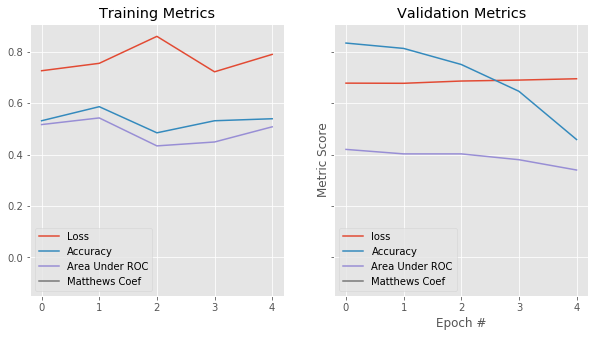

In [246]:
history_plotter(history=conv_history, plot_validation=True)

# Object Detection via Transfer Learning


In [267]:
pretrained_mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet')
pretrained_mobilenet.trainable = False

In [286]:
mnet_model = tf.keras.models.Sequential()
mnet_model.add(pretrained_mobilenet)
mnet_model.add(tf.keras.layers.GlobalAveragePooling2D())
mnet_model.add(tf.keras.layers.Dense(64))
mnet_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

mnet_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=10*learning_rate),
              loss=loss,
              metrics=METRICS)
mnet_model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_24  (None, 1280)              0         
_________________________________________________________________
dense_86 (Dense)             (None, 64)                81984     
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 65        
Total params: 2,340,033
Trainable params: 82,049
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
mnet_history = mnet_model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_train_samples/batch_size),  
        epochs=n_epochs,
        verbose=1,
        validation_data=vdate_generator,
        validation_steps=int(total_vdate_samples/batch_size),
        class_weight=class_weight,
        use_multiprocessing=False)

Epoch 1/5
16/16 [==============================] - 78s 5s/step - loss: 0.7305 - accuracy: 0.6250 - auc: 0.5962 - matthews_correlation: nan - val_loss: 0.6938 - val_accuracy: 0.5833 - val_auc: 0.4140 - val_matthews_correlation: nan
Epoch 2/5
16/16 [==============================] - 73s 5s/step - loss: 0.6591 - accuracy: 0.6250 - auc: 0.6668 - matthews_correlation: nan - val_loss: 0.6887 - val_accuracy: 0.5833 - val_auc: 0.4337 - val_matthews_correlation: nan
Epoch 3/5
15/16 [===========================>..] - ETA: 4s - loss: 0.7091 - accuracy: 0.6167 - auc: 0.6685 - matthews_correlation: 0.1824

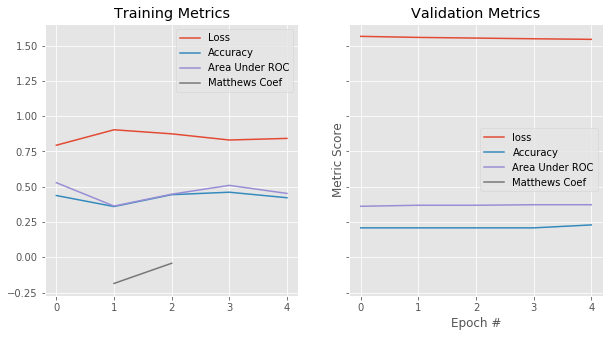

In [285]:
history_plotter(mnet_history)

# Object Segmentation
This will use a pretrained model as the basis for a nn that identifies the part of an image file that contains the sidewalk object.

### tinyYOLOv3

In [262]:
model_path = "./models/yolo-tiny.h5"
input_path = "./input/test45.jpg"
output_path = "./output/newimage.jpg"

In [264]:
detector = ObjectDetection().get
detector.setModelTypeAsTinyYOLOv3()
detector.setModelPath(model_path)
detector.loadModel()

#returns dictionary with name and probabilities of objects detected
detection = detector.detectObjectsFromImage(input_image=input_path, output_image_path=output_path)

RuntimeError: `get_session` is not available when using TensorFlow 2.0.

In [ ]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = SentimentService.get_model1()
#New code to load model
def load_deep_model(self, model):
        loaded_model = tf.keras.models.load_model("./src/mood-saved-models/"model + ".h5")
        return loaded_model
    
    
    detector = ObjectDetection()
detector.setModelTypeAsTinyYOLOv3()
detector.setModelPath(model_path)
detector.loadModel()

#returns dictionary with name and probabilities of objects detected
detection = detector.detectObjectsFromImage(input_image=input_path, output_image_path=output_path)

### MobileNetV2




In [ ]:
xcept_model = tf.keras.applications.Xception(weights='imagenet')
#http://download.tensorflow.org/models/deeplab_cityscapes_xception71_trainfine_2018_09_08.tar.gz
